# 4. Creating your own Environment: News Vendor

In this notebook, we will cover how you can create your own Reinforcement Learning environment that conforms to the [Gymnasium](https://gymnasium.farama.org/) interface/API provided by the Farama Foundation. 

## Why should we conform to this API?
An API (application‑programming interface) is simply a set of function signatures and data conventions: `reset()`, `step()`, `observation_space`, etc. that any compliant environment must expose. Think of it as the rules of the road that let agents and environments plug into each other without surprises.

When your environment follows this contract, every agent implementation in the Gymnasium ecosystem (Stable‑Baselines 3, CleanRL, RLlib, Ray Tune, etc.) can train on it instantly without any glue code nor hacky workarounds. Thus, you gain **interoperability.** Moreover, you gain free **additional tooling** by inheriting Gymnasium’s wrappers, vectorized execution helpers, monitoring utilities, and visualizers, saving you from reinventing episode logging, *video capture*, or parallel rollouts.

In [1]:
from utils.grader import make_tester, run_tests
from notebooks.internal.exercises_4_news_vendor import *

## Specifying Environments
Specifying an environment corresponds to specifying a *Markov Decision Process*, as you might have optionally read within Notebook 2. Without going into all the formal jargon and math, here's what we need to specify:
- **State space**: What are the possible states of the system we can be in, reached by taking actions from the initial state?
- **Action space**: What actions can be taken by the agent?
    - An **action mask** can also optionally be provided if applicable to the environment.
- **Transition function**: if probabilistic transitions are involved from taking actions in states, then you must also provide the accompanying transition probabilities. You are in control of how the agent moves through the environment as you are the **environment designer**.
- **Reward function**: by convention, the environment provides a reward function that serves as some sort of ground truth. For example, in Monty Hall, if they gain a car we can provide a reward of 100, and if they gain a goat, we could provide a lesser reward of 10.
    - Users can override your reward function if they would like to try something else though just by implementing a wrapper: that's just a slice of the expressive power you gain by using Gymnasium!

## News Vendor
Here, we are covering an environment called the **News Vendor** problem. While an implementation of this already exists in [OR-gym](https://github.com/hubbs5/or-gym), we will try to implement it from scratch to try to understand the environment creation process from scratch.

> The (multi‑period) **News Vendor problem** models a trader who must decide how many perishable units to order *before* seeing demand that is random but statistically known. Ordering too much leaves leftover inventory that incurs holding or disposal costs, while ordering too little produces lost‑sales penalties or forgone margin; the optimal quantity balances these two expected costs at the critical ratio where the probability of selling an extra unit equals the ratio of under‑stocking cost to the sum of under‑ and over‑stocking costs.

At the end of each period, stock that was not sold is "expired" (removed) and a holding penalty is applied for any excess stock. A goodwill penalty (shortage penalty) is applied if stock is not held despite it being in demand. Demand is probabilistically modelled. The agent observes stochastic price, cost, holding - and shortage‑penalty parameters plus an order‑pipeline vector, chooses a non‑negative order up to capacity each step, and receives profit (sales revenue minus discounted purchase, holding, and shortage costs). 

Therefore, this problem is a seminal problem that arises in inventory management, in terms of fast-moving consumer goods (FMCGs) and procurement.

You are able to play the environment in `notebooks/extras/play_news_vendor.ipynb` if you would like to see how it works before proceeding, as it already comes with batteries attached (visualisation), see below for an example:

<figure style="text-align:center;">
  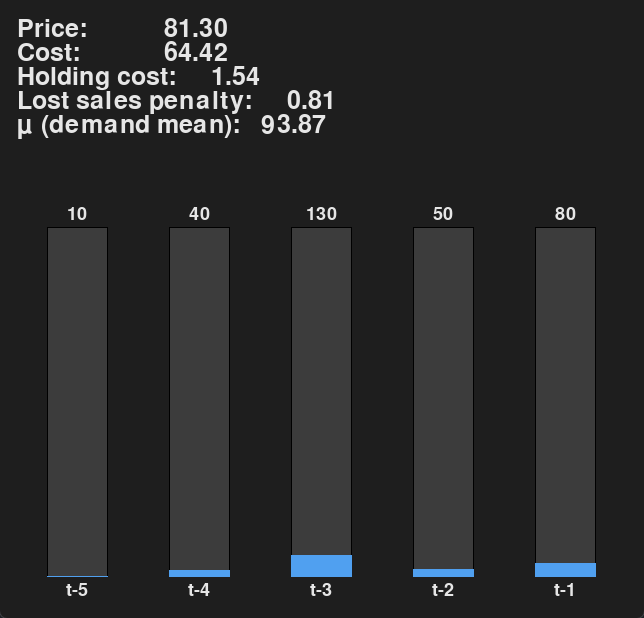
  <figcaption>Figure of the News Vendor Environment visualised</figcaption>
</figure>



The classic single-product News Vendor problem is not considered a combinatorial-optimization problem; it is a continuous, single-variable stochastic optimization. However, many *extensions* of the problem, particularly those that add integer quantities, multiple items, or other discrete choices do turn it into a combinatorial problem. In this notebook, the focus is on the actual modelling of an environment in terms of the API - you can apply the same principles to combinatorial and non-combinatorial problems, and this is easy enough to model.

## Conforming to Gymnasium's API

### Spaces
Think of each space as a contract that tells an RL agent (and you!) what valid actions and observations look like.

| Space         | What it represents                                                                                                          | Quick constructor                           | Typical use                                                                                   | Tiny demo                                                                                                                             |
|---------------|-----------------------------------------------------------------------------------------------------------------------------|---------------------------------------------|------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------|
| Box           | An n‑dimensional box of real or integer values (each dimension has its own lower/upper bound, possibly plus/minus infinity) | Box(low, high, shape, dtype)               | Continuous actions (torques, joystick axes) or vector observations (positions, pixel stacks). | `from gymnasium.spaces import Box; obs = Box(-1.0, 1.0, shape=(3,), dtype=float32); print(obs.sample())  # e.g. [-0.12  0.77 -0.55]` |
| Discrete      | A finite set of consecutive integers {start, ..., start+n‑1}.                                                               | Discrete(n, start=0)                       | Classic control actions (left/right), indexes into lookup tables.                             | `action = Discrete(3)  # {0,1,2}; print(action.sample()) `                                                                         |
| MultiBinary   | A fixed‑shape binary array (0/1).                                                                                            | MultiBinary(n) or MultiBinary((rows, cols)) | Keyboards, on/off sensors, one‑hot vectors.                                                   | `keys = MultiBinary(8); print(keys.sample())`                                                                                     |
| MultiDiscrete | Cartesian product of several independent Discrete spaces, each with its own range.                                          | MultiDiscrete([n0, n1, ...]) (or ndarray)  | Game‑controller combos: e.g. arrow‑keys x fire x jump.                                        | `pad = MultiDiscrete([5, 2, 2]); print(pad.sample())  # e.g. [3 0 1]`                                                             |
| Text          | Variable‑length strings drawn from a character set.                                                                         | Text(max_len, min_len=1, charset=...)      | Natural‑language prompts, serial numbers, chat messages.                                      | `txt = Text(10); print(txt.sample())`                                                                                             |


In this exemplar, we will only consider `Discrete` and `Box` spaces.

Every space must have a known-size at initialization, e.g. `Discrete(n)`. For example, in Monty Hall, you can open one of three doors, so there's three actions. After revealing the first door, you can't choose a revealed door, but there are still 3 actions that can be constrained by action masking such to only allow the agent or user to pick only from the set of 2 valid actions. 

You can view more details in the [Gymnasium documentation](https://gymnasium.farama.org/api/spaces/).

### The 'Contract' required

Gymnasium also provides a couple of tutorials for creating a simple Gridworld environment [here](https://gymnasium.farama.org/introduction/create_custom_env/) and a more complete tutorial [with rendering](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/).

There are actually only four functions required to implement an environment as mandated by Gymnasium:
* **`step`**

  * Signature:

    ```python
    def step(self, action: ActType) -> tuple[ObsType, float, bool, bool, dict[str, Any]]
    ```
  * Advances the environment one time‑step and returns the next observation, reward, `terminated`, `truncated`, and an `info` dictionary.

* **`reset`**

  * Signature:

    ```python
    def reset(
        self,
        *,
        seed: int | None = None,
        options: dict[str, Any] | None = None
    ) -> tuple[ObsType, dict[str, Any]]
    ```
  * Starts a new episode (optionally reseeding RNG and/or passing episode‑level options). Returns the initial observation and an `info` dictionary.

* **`render`**

  * Signature:

    ```python
    def render(self) -> RenderFrame | list[RenderFrame] | None
    ```
  * Produces a visual or textual representation of the current state, depending on the `render_mode` selected when the environment was created. Returns a frame, a list of frames, or `None`.

* **`close`**

  * Signature:

    ```python
    def close(self) -> None
    ```
  * Frees external resources (windows, simulators, files, sockets) and can be called multiple times safely.

Other than this, the class specified must be:
* The class should expose a top-level attribute called metadata, something along the lines of:
    * `    metadata = {"render_modes": ["human"], "render_fps": 4}`
    * All render modes should be specified and the rendering frames per second.
* The class should have two properties, `self.action_space` and `self.observation_space` that states what type of space is used for each (e.g. Discrete, Box, MultiDiscrete) and what size/dimensions these spaces are (this must be known at initialisation time of the class).

Optionally, for usage of environment creation by name within `make_env()`, you should use the `register()` function, an example is shown later in this notebook

## Implementation

Here, the implementation is left as an exercise for you to complete out some of the stubbed out code (marked as `@Solve`):

In [2]:
from dataclasses import dataclass

import numpy as np
from collections.abc import Iterable
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register

# ──────────────────────────────────────────────────────────────────────────────── #
#                                 Configuration                                    #
# ──────────────────────────────────────────────────────────────────────────────── #
@dataclass
class NewsVendorConfig:
    # ── Demand / system limits ──
    lead_time: int = 5                 # periods before an order arrives
    max_inventory: int = 4_000         # cap on pipeline + on‑hand units
    max_order_quantity: int = 2_000    # upper bound for a single action

    # ── Cost parameters (upper bounds for random sampling) ──
    max_sale_price: float = 100.0
    max_holding_cost: float = 5.0
    max_lost_sales_penalty: float = 10.0
    max_demand_mean: float = 200.0              # Poisson mean upper bound

    # ── Episode & discount ──
    max_steps: int = 40
    gamma: float = 1.0                 # discount on purchase cost

class NewsVendorEnv(gym.Env):
    """Gymnasium implementation of the classic multi-period news-vendor problem."""

    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(
        self,
        *,
        config: NewsVendorConfig = NewsVendorConfig(),
        render_mode: str | None = None,
        seed: int | None = None,
    ) -> None:
        """ A Gymnasium interface of the Multi-Period News Vendor with Lead Times from Balaji et. al.

        The News Vendor problem is a seminal problem within inventory management, see: 
            Foundations of Inventory Management (Zipkin, 2000)

        Inventory orders are not instantaneous and have multi-period leadtimes. There are costs inccured for holding
        unsold inventory, although unsold inventory expires at the end of each period. There are also penalties
        associated with losing goodwill by having unsold inventory.

        Observation:
            Type: Box
            State Vector: S = (p, c, h, k, mu, x_l, x_l-1)
            p = price
            c = cost
            h = holding cost
            k = lost sales penalty
            mu = mean of demand distribution
            x_l = order quantities in the queue

        Initial state:
            Parameters p, c, h, k, and mu, with no inventory in the pipeline.

        Actions:
            Type: Box
            Amount of product to order.

        Reward:
            Sales minus discounted purchase price, minus holding costs for
            unsold product or penalties associated with insufficient inventory.

        Episode termination:
            By default, the environment terminates within 40 time steps.
        """
        
        self.config = config
        self.render_mode = render_mode

        # ╭─────────────────── Observation space ───────────────────╮
        # state = [p, c, h, k, μ, pipeline_1,  …, pipeline_n]
        #                          ↑        ↑
        #                          newest   next to arrive
        self.obs_dim = self.config.lead_time + 5
        self.observation_space = spaces.Box(
            low=np.zeros(self.obs_dim, dtype=np.float32),
            high=np.array(
                [self.config.max_sale_price,        # p
                 self.config.max_sale_price,        # c  (bounded by price)
                 self.config.max_holding_cost,      # h
                 self.config.max_lost_sales_penalty,# k
                 self.config.max_demand_mean]                # μ
                + [self.config.max_order_quantity] * self.config.lead_time,
                dtype=np.float32,
            ),
        )

        # ─── Action space ─── #
        self.action_space = spaces.Box(
            low=np.array([0.0], dtype=np.float32),
            high=np.array([self.config.max_order_quantity], dtype=np.float32),
        )

        # ─── renderer (optional) ───
        self._renderer = None

        # ─── Initialisation ─── #
        self.state = self.reset(seed=seed)

    # ──────────────────────────────────────────────────────────────────────────────── #
    #                                Private helpers                                   #
    # ──────────────────────────────────────────────────────────────────────────────── #
   
    def _sample_economic_parameters(self) -> None:
        """Draw random price/cost/penalties for a fresh episode."""
        self.price = max(1.0, self.np_random.random() * self.config.max_sale_price)
            
        # @Solve: sample ∼ U(0, price) then lower‑bound at 1.0
        self.cost = ...   # ← Unit purchase cost ≤ price
        
        self.holding_cost_rate     = self.np_random.random() * min(self.cost, self.config.max_holding_cost)
        
        # @Solve: sample ∼ U(0, max_lost_sales_penalty)
        self.lost_sales_penalty = ...  # ← goodwill‑loss penalty
        
        self.mu    = self.np_random.random() * self.config.max_demand_mean # mu = max demand mean
    
    def _reset_state(self) -> np.ndarray:
        """Reset economic parameters and clear the pipeline."""
        self._sample_economic_parameters()
        pipeline = np.zeros(self.config.lead_time, dtype=np.float32)
        self.current_step = 0
        return np.concatenate((
            np.array([self.price, self.cost, self.holding_cost_rate, self.lost_sales_penalty, self.mu], dtype=np.float32),
            pipeline,
        ))

    # ──────────────────────────────────────────────────────────────────────────────── #
    #                                 Gymnasium API                                    #
    # ──────────────────────────────────────────────────────────────────────────────── #
    def reset(self, *, seed: int | None = None, options=None):
        """Resets the environment, whenever an episode has terminated or is beginning.

        Args:
            seed (int or None): reset the environment with a specific seed value. Defaults to None.
            options: unused, mandated by the Gymnasium interface. Defaults to None.

        Returns:
            State vector
        """
        super().reset(seed=seed)

        self.state = self._reset_state()
        return self.state

    def step(self, action):
        # ── 1: Ensure scalar float ──
        if isinstance(action, (np.ndarray, list)):
            action = float(np.asarray(action).flatten()[0])
        order_qty = np.clip(
            action,
            0.0,
            min(
                self.config.max_order_quantity,
                self.config.max_inventory - self.state[5:].sum(),
            ),
        )

        # ── 2: Demand for this period ──
        demand = self.np_random.poisson(lam=self.mu)

        # ── 3: Inventory available today ──
        pipeline = self.state[5:]
        inv_on_hand = order_qty if self.config.lead_time == 0 else pipeline[0]

        # ── 4: Sales outcomes ──
        sales_revenue   = min(inv_on_hand, demand) * self.price
        excess_inventory = max(0.0, inv_on_hand - demand)
        short_inventory  = max(0.0, demand - inv_on_hand)

        # ── 5: Costs ──
        purchase_cost      = order_qty * self.cost * (self.config.gamma ** self.config.lead_time)
        # @Solve
        holding_cost       = ...
        # @Solve
        lost_sales_penalty = ...

        # ── 6: Reward ──
        reward = sales_revenue - purchase_cost - holding_cost - lost_sales_penalty
        if isinstance(reward, Iterable):
            reward = float(np.squeeze(reward))

        # ── 7: Advance pipeline ──
        new_pipeline = np.zeros(self.config.lead_time, dtype=np.float32)
        if self.config.lead_time > 0:
            new_pipeline[:-1] = pipeline[1:]
            new_pipeline[-1]  = order_qty
        self.state = np.hstack([self.state[:5], new_pipeline]).astype(np.float32)

        # ── 8: Episode termination ──
        self.current_step += 1
        terminated = self.current_step >= self.config.max_steps
        truncated  = False  # No time‑limit truncation beyond max_steps

        return self.state, reward, terminated, truncated, {}

    def render(self, mode: str | None = None):
        if self.render_mode is None:
            return None
            
        if not self._renderer:
            raise ValueError("render_mode was None when env was created.")
        return self._renderer.render(self.state)

    def close(self):
        """Closes the environment, performing some basic cleanup of resources."""
        if self._renderer:
            self._renderer.close()
            self._renderer = None

# ──────────────────────────────────────────────────────────────────────────────── #
#               Register so users can call gymnasium.make()                        #
# ──────────────────────────────────────────────────────────────────────────────── #
register(
    id="NewsVendor-v0",
    entry_point="environments.news_vendor.env:NewsVendorEnv",
    max_episode_steps=NewsVendorConfig().max_steps,
)

In [3]:
# Check your code here - don't modify this cell!
def economic_parameters(seed: int):
    """Return (p, c, h, k, μ) after env.reset(seed)."""
    env = NewsVendorEnv()
    env.reset(seed=seed)
    return (env.price,
            env.cost,
            env.holding_cost_rate,
            env.lost_sales_penalty,
            env.mu)

def first_step_reward(seed: int, action: float):
    """Reward obtained from the very first step after env.reset(seed)."""
    env = NewsVendorEnv()
    env.reset(seed=seed)
    _, reward, *_ = env.step(action)
    return reward

make_tester(economic_parameters, economic_parameter_cases)
make_tester(first_step_reward, first_step_reward_cases)

# Conclusion
With this notebook, we have discovered on how you can model any combinatorial problem as a Reinforcement Learning environment using the Gymnasium API. The Gymnasium API is the most popular API for modelling RL environments, aside from multi-agent RL, which typically uses **PettingZoo** (which is just an extension of Gymnasium to handle both parallel and turn-based multi-agent RL).

Notice how the environment we implemented here uses a `Box()` space, so is not directly trainable with our Tabular Q-Learning implementation, but function approximation based extensions of Tabular Q-Learning will allow compatibility. If you are able to implement the visualisation extension, that is more than sufficient. You can implement a stronger algorithm to support this environment (which also serves as your motivation!) after going through the conclusion notebook.

The next notebook will conclude this exemplar, however, the conclusion provides a quite comprehensive yet accessible literature review of the state-of-the-art for solving combinatorial problems using RL. Therefore, it is definitely worth reading!

# Extensions
---

## Extension 1. Implementing a Renderer
At the moment, while we can interface with the environment through code, there's no way to interactively play the environment as an user. This is helpful for both visualisation and debugging, to make sure your environment is working as intended.

Try implementing "ANSI" rendering (console text) and write some code that allows you to interactively provide input (in terms of action) at each step. For how rendering works, you may find it useful to refer to the Monty Hall environment at `src/environments/monty_hall` and consult the Gymnasium documentation at the following URLs:
- https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/
- https://gymnasium.farama.org/api/env/#gymnasium.Env.render

## Extension 2. Action Masking
1) Explore the code for the Monty Hall environment provided in the repository at `src/environments/monty_hall`.
2) Explain how Action Masking is implemented there and used in Tabular Q Learning at `src/rl/tabular_q_learning.py`.

## Extension 3. Recording your Agent
In Notebook 3, we learnt that during training, we can visualise the cumulative returns of our agent to monitor how well they are performing, since a higher reward equates to better performance.

Another common method, and a nice visualisation tool, is viewing recordings of how your agent is performing. This requires sometimes additional processing, but you do not have to record your environment at every time step. 

For this extension, copy your code from Notebook 3 on the Monty Hall environment, instead of using this particular environment (as Tabular Q-Learning is not applicable here). You can proceed by reading [this documentation](https://gymnasium.farama.org/introduction/record_agent/) on the Gymnasium website.

## Extension 4. Make the Environment Combinatorial
Try adding an additional product to the environment, thus making this environment combinatorial.